###Multi-class classifier: Drone vs Passenger Plane  vs Helicopter

1. Import of libraries
2. Loading data
3. Preparation of training, validation and test collections
4. Data mining
5. Data augmentation
6. Model building
7. Transfer learning (VGG19 model - unfreezing the last few layers) 
8. Model evaluation on test set 
9. Display prediction errors 
10. Summary
11. References

##Import of libraries

In [103]:
%tensorflow_version 2.x
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import VGG19

np.set_printoptions(precision=6, suppress=True)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


##Loading data

In [104]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


##Preparation of training, validation and test collections

In [105]:
!rm -rf ./images # cleaning the workspace

I create paths to our base files: (base_dir - base directory), listing the elements contained in our collection. I select from the resulting three classes - the minimum of these collections. 


In [106]:
base_dir = '/content/drive/MyDrive/data/planes'
raw_number_of_files = {}
classes = ['drone', 'passenger_plane', 'helicopter']

for dir in classes:
    raw_number_of_files[dir] = len(os.listdir(os.path.join(base_dir, dir)))

raw_number_of_files.items()    

dict_items([('drone', 1259), ('passenger_plane', 1245), ('helicopter', 1321)])

I create directories to train the generators from these files. I create three paths to the training collection, the validation collection and the test collection. I create three directories in each of these collections (drone, passenger_plane, helicopter). I do the same with the validation collection and the test collection.

In [107]:
data_dir = './images'

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

train_dir = os.path.join(data_dir, 'train')    
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

train_drone_dir = os.path.join(train_dir, 'drone')
train_passenger_plane_dir = os.path.join(train_dir, 'passenger_plane')
train_helicopter_dir = os.path.join(train_dir, 'helicopter')

valid_drone_dir = os.path.join(valid_dir, 'drone')
valid_passenger_plane_dir = os.path.join(valid_dir, 'passenger_plane')
valid_helicopter_dir = os.path.join(valid_dir, 'helicopter')

test_drone_dir = os.path.join(test_dir, 'drone')
test_passenger_plane_dir = os.path.join(test_dir, 'passenger_plane')
test_helicopter_dir = os.path.join(test_dir, 'helicopter')

for directory in (train_dir, valid_dir, test_dir):
    if not os.path.exists(directory):
        os.mkdir(directory)

dirs = [train_drone_dir, train_passenger_plane_dir, train_helicopter_dir, 
        valid_drone_dir, valid_passenger_plane_dir, valid_helicopter_dir, 
        test_drone_dir, test_passenger_plane_dir, test_helicopter_dir]        

for dir in dirs:
    if not os.path.exists(dir):
        os.mkdir(dir)

I retrieve the file names thanks to the 'os' library, create three lists with the names. Then I do a validation - I leave the files with extensions 'jpg', 'png', and 'jpeg'. 
I will then take the minimum from the amount of data I have in these three directories. The size of the test collection will be 70%, the validation 20% and the test 10%, I create the indexes straight away. In the next block of code I populate the directories, copy the files - using the 'shutil.copyfile' library (source--> destination). I do this for each set ('drone', 'passenger_plane', 'helicopter'). 
I then do some light validation - checking that the numbers in the training, validation and test sets match.

In [108]:
drone_file_names = os.listdir(os.path.join(base_dir, 'drone'))
passenger_file_names = os.listdir(os.path.join(base_dir, 'passenger_plane'))
helicopter_file_names = os.listdir(os.path.join(base_dir, 'helicopter'))

drone_file_names = [file_name for file_name in drone_file_names if 
                    file_name.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
passenger_file_names = [file_name for file_name in passenger_file_names if 
                        file_name.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
helicopter_file_names = [file_name for file_name in helicopter_file_names if 
                    file_name.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]                       

In [109]:
size = min(len(drone_file_names), len(passenger_file_names), len(helicopter_file_names))

train_size = int(np.floor(0.7 * size))
valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size

train_index = train_size
valid_index = train_size + valid_size
test_index = train_size + valid_size + test_size

In [110]:
for index, fill_name in enumerate(drone_file_names):
    if index <= train_index:
        source = os.path.join(base_dir, 'drone', fill_name)
        destination = os.path.join(train_drone_dir, fill_name)
        shutil.copyfile(source, destination)
    elif train_index < index <= valid_index:
        source = os.path.join(base_dir, 'drone', fill_name)
        destination = os.path.join(valid_drone_dir, fill_name)
        shutil.copyfile(source, destination)
    elif valid_index < index < test_index:
        source = os.path.join(base_dir, 'drone', fill_name)
        destination = os.path.join(test_drone_dir, fill_name)
        shutil.copyfile(source, destination)

for index, fill_name in enumerate(passenger_file_names):
    if index <= train_index:
        source = os.path.join(base_dir, 'passenger_plane', fill_name)
        destination = os.path.join(train_passenger_plane_dir, fill_name)
        shutil.copyfile(source, destination)
    elif train_index < index <= valid_index:
        source = os.path.join(base_dir, 'passenger_plane', fill_name)
        destination = os.path.join(valid_passenger_plane_dir, fill_name)
        shutil.copyfile(source, destination)
    elif valid_index < index < test_index:
        source = os.path.join(base_dir, 'passenger_plane', fill_name)
        destination = os.path.join(test_passenger_plane_dir, fill_name)
        shutil.copyfile(source, destination)    

for index, fill_name in enumerate(helicopter_file_names):
    if index <= train_index:
        source = os.path.join(base_dir, 'helicopter', fill_name)
        destination = os.path.join(train_helicopter_dir, fill_name)
        shutil.copyfile(source, destination)
    elif train_index < index <= valid_index:
        source = os.path.join(base_dir, 'helicopter', fill_name)
        destination = os.path.join(valid_helicopter_dir, fill_name)
        shutil.copyfile(source, destination)
    elif valid_index < index < test_index:
        source = os.path.join(base_dir, 'helicopter', fill_name)
        destination = os.path.join(test_helicopter_dir, fill_name)
        shutil.copyfile(source, destination)           

print(f'drone - training collections {len(os.listdir(train_drone_dir))}')
print(f'drone - validation collections {len(os.listdir(valid_drone_dir))}')
print(f'drone - test collections {len(os.listdir(test_drone_dir))}')

print(f'passenger_plane - training collections {len(os.listdir(train_passenger_plane_dir))}')
print(f'passenger_plane - validation collections {len(os.listdir(valid_passenger_plane_dir))}')
print(f'passenger_plane - test collections {len(os.listdir(test_passenger_plane_dir))}')

print(f'helicopter - training collections {len(os.listdir(train_helicopter_dir))}')
print(f'helicopter - validation collections {len(os.listdir(valid_helicopter_dir))}')
print(f'helicopter - test collections {len(os.listdir(test_helicopter_dir))}')

drone - training collections 864
drone - validation collections 246
drone - test collections 124
passenger_plane - training collections 864
passenger_plane - validation collections 246
passenger_plane - test collections 124
helicopter - training collections 864
helicopter - validation collections 246
helicopter - test collections 124


After validation, it can be seen that we only have 864 training samples, 246 validation samples and 124 test samples. This is not enough to train the model from scratch. So I will use 'transfer learning'.

##Data mining

(-0.5, 499.5, 499.5, -0.5)

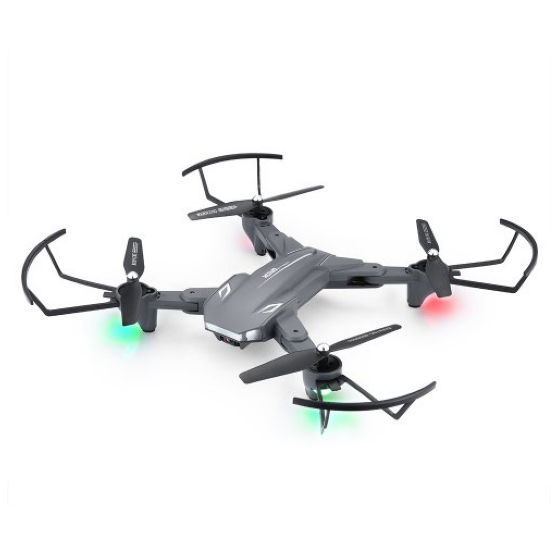

In [111]:
#@title Select the index of a sample drone image from the training collection:

index = 212 #@param {type:'slider', min:0, max:864}
names_mapping = dict(enumerate(drone_file_names))
image_path = os.path.join(train_drone_dir, names_mapping[index])

img = image.load_img(image_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 1023.5, 767.5, -0.5)

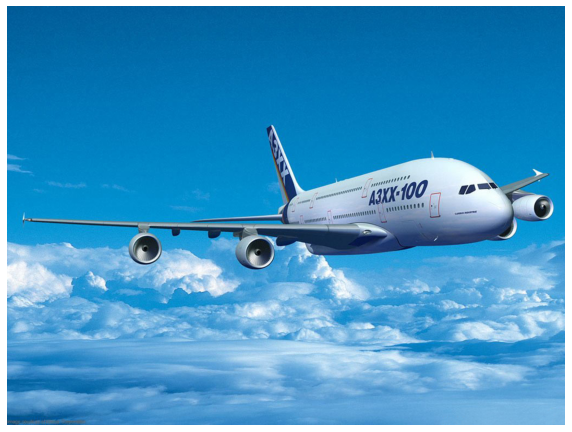

In [112]:
#@title Select the index of an example passenger aircraft photo from the training collection:

index = 160 #@param {type:'slider', min:0, max:864}
names_mapping = dict(enumerate(passenger_file_names))
image_path = os.path.join(train_passenger_plane_dir, names_mapping[index])

img = image.load_img(image_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 1599.5, 1155.5, -0.5)

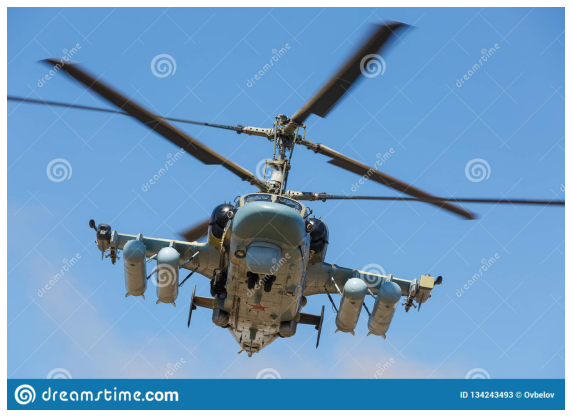

In [113]:
#@title Select the index of a sample helicopter image from the training collection:

index = 282 #@param {type:'slider', min:0, max:864}
names_mapping = dict(enumerate(helicopter_file_names))
image_path = os.path.join(train_helicopter_dir, names_mapping[index])

img = image.load_img(image_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

##Data augmentation

 I will use the 'ImageDataGenerator' class for the training set with the selected parameters. I then scale the data from the validation set (throw in just one parameter, no other transformations). Builds a generator on the training set, and the validation set.

In [114]:
train_datagen = ImageDataGenerator(
    rotation_range=40, # the range by which a random turn will be performed
    rescale=1./255.,
    width_shift_range=0.2, # vertical image transformations
    height_shift_range=0.2, # horizontal image transformation
    shear_range=0.2, # range of random image cropping
    zoom_range=0.2, # random zoom range
    horizontal_flip=True, # random reflection of half of the image in the horizontal plane
    fill_mode='nearest' # strategy for filling the newly created pixels
)

# Rescaling of all images by a factor of 1/255
valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='categorical')

Found 2592 images belonging to 3 classes.
Found 738 images belonging to 3 classes.


In [115]:
def display_augmented_images(directory, index):
    """
    The function returns a graph of sample images obtained using 
    the data augmentation technique.
    """
    fill_names = [os.path.join(directory, fill_name) for fill_name in os.listdir(directory)]
    image_path = fill_names[index]
    img = image.load_img(image_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1, ) + x.shape)

    i = 1
    plt.figure(figsize=(16, 8))
    for batch in train_datagen.flow(x , batch_size=1):
        plt.subplot(3, 4, i)
        plt.grid(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 13 == 0:
            break

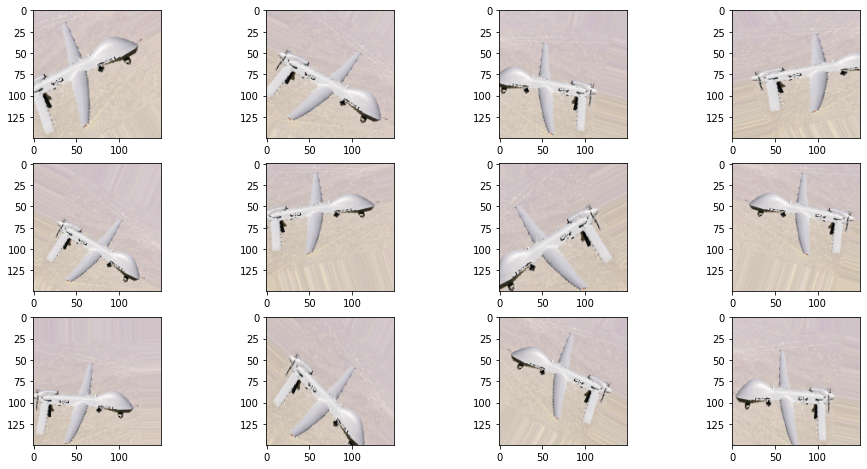

In [116]:
#@title Training drone collection:
index = 31 #@param {type:'slider', min:0, max:864}
display_augmented_images(train_drone_dir, index)

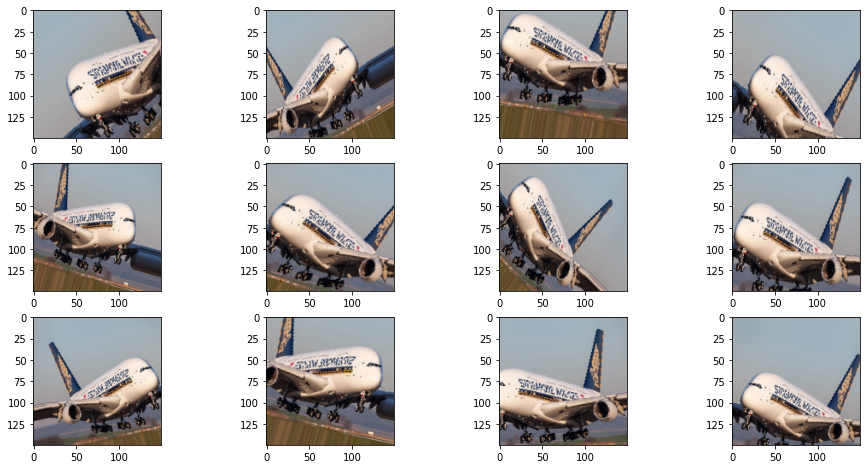

In [117]:
#@title Training passenger plane collection:
index = 256 #@param {type:'slider', min:0, max:864}
display_augmented_images(train_passenger_plane_dir, index)

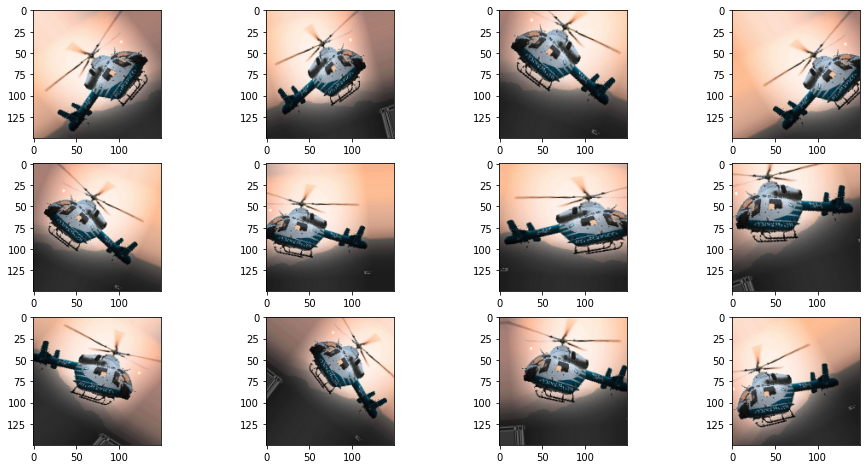

In [118]:
#@title Training helicopter collection:
index = 31 #@param {type:'slider', min:0, max:864}
display_augmented_images(train_helicopter_dir, index)

##Model building

In [119]:
batch_size = 32
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size

##Transfer learning (VGG19 model - unfreezing the last few layers)

In [120]:
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.trainable = True

def print_layers(model):
    for layer in model.layers:
        print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

print_layers(conv_base) # Printing all layers of the model

layer_name: input_3       trainable: True
layer_name: block1_conv1  trainable: True
layer_name: block1_conv2  trainable: True
layer_name: block1_pool   trainable: True
layer_name: block2_conv1  trainable: True
layer_name: block2_conv2  trainable: True
layer_name: block2_pool   trainable: True
layer_name: block3_conv1  trainable: True
layer_name: block3_conv2  trainable: True
layer_name: block3_conv3  trainable: True
layer_name: block3_conv4  trainable: True
layer_name: block3_pool   trainable: True
layer_name: block4_conv1  trainable: True
layer_name: block4_conv2  trainable: True
layer_name: block4_conv3  trainable: True
layer_name: block4_conv4  trainable: True
layer_name: block4_pool   trainable: True
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_conv4  trainable: True
layer_name: block5_pool   trainable: True


In [121]:
"""
I set the flag to start training from layer 'block5_conv1' 
(I freeze the rest of the layers).
"""
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print_layers(conv_base)

layer_name: input_3       trainable: False
layer_name: block1_conv1  trainable: False
layer_name: block1_conv2  trainable: False
layer_name: block1_pool   trainable: False
layer_name: block2_conv1  trainable: False
layer_name: block2_conv2  trainable: False
layer_name: block2_pool   trainable: False
layer_name: block3_conv1  trainable: False
layer_name: block3_conv2  trainable: False
layer_name: block3_conv3  trainable: False
layer_name: block3_conv4  trainable: False
layer_name: block3_pool   trainable: False
layer_name: block4_conv1  trainable: False
layer_name: block4_conv2  trainable: False
layer_name: block4_conv3  trainable: False
layer_name: block4_conv4  trainable: False
layer_name: block4_pool   trainable: False
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_conv4  trainable: True
layer_name: block5_pool   trainable: True


In [122]:
model = Sequential() # Builds a model of the 'Sequential' class
model.add(conv_base) # Adds a base model
model.add(layers.Flatten()) # I flatten the data
model.add(layers.Dense(units=256, activation='relu')) # Dense network: 256 neurons
model.add(layers.Dense(units=3, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-5), # Compiles the model  
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary() # Summary of the model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                                 
Total params: 22,122,563
Trainable params: 11,537,411
Non-trainable params: 10,585,152
_________________________________________________________________


In [123]:
# Adjusts the generator
history = model.fit_generator(generator=train_generator, 
                              steps_per_epoch=steps_per_epoch,
                              epochs=40, 
                              validation_data=valid_generator, 
                              validation_steps=validation_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/40
26/26 [==============================] - 27s 995ms/step - loss: 1.0542 - accuracy: 0.4339 - val_loss: 0.8415 - val_accuracy: 0.7098
Epoch 2/40
26/26 [==============================] - 22s 872ms/step - loss: 0.9272 - accuracy: 0.5649 - val_loss: 0.6784 - val_accuracy: 0.7545
Epoch 3/40
26/26 [==============================] - 23s 903ms/step - loss: 0.8406 - accuracy: 0.6214 - val_loss: 0.5843 - val_accuracy: 0.7902
Epoch 4/40
26/26 [==============================] - 24s 935ms/step - loss: 0.7844 - accuracy: 0.6430 - val_loss: 0.5491 - val_accuracy: 0.7768
Epoch 5/40
26/26 [==============================] - 23s 883ms/step - loss: 0.7022 - accuracy: 0.7127 - val_loss: 0.4818 - val_accuracy: 0.8080
Epoch 6/40
26/26 [==============================] - 22s 862ms/step - loss: 0.6809 - accuracy: 0.6899 - val_loss: 0.5041 - val_accuracy: 0.7812
Epoch 7/40
26/26 [==============================] - 23s 911ms/step - loss: 0.6117 - accuracy: 0.7308 - val_loss: 0.4725 - val_accuracy: 0.7991

Please note that the data that is uploaded to the model is generated 'on the fly', using this generator on the basis of the images that are in the indicated folders (hence training these models takes more time).

In [124]:
# Display of metrics after overharvesting
def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs Val Accuracy', xaxis_title='Epochs', yaxis_title='Accuracy')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Loss vs Val Loss', xaxis_title='Epochs', yaxis_title='Loss')#yaxis_type???
    fig.show()

plot_hist(history)

##Model evaluation on test set

In [125]:
# Checking how the model performs on data it has not seen before
# Creation of a generator for test data
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=1,
    class_mode='categorical', 
    shuffle=False
)

# I use the 'predict_generator' method to get class predictions
# 'predict_generator' returned probabilities of belonging to three classes
y_prob = model.predict_generator(test_generator, test_generator.samples)
y_prob

Found 372 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



array([[0.931734, 0.004572, 0.063694],
       [0.978456, 0.003223, 0.01832 ],
       [0.891732, 0.007443, 0.100826],
       ...,
       [0.000822, 0.002354, 0.996824],
       [0.089709, 0.000205, 0.910086],
       [0.053681, 0.010862, 0.935457]], dtype=float32)

In [126]:
y_pred = np.argmax(y_prob, axis=1)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 2, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 2, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 0, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,

In [127]:
# I create a DataFrame object with the resulting predictions
predictions = pd.DataFrame({'class':y_pred})
predictions

,class
0,0
1,0
2,0
3,0
4,0
...,...
367,2
368,2
369,2
370,2


In [128]:
# Uses the 'real' classes that were assigned to our test set, 
# using the 'classes' attribute from our test data generator
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [129]:
# Assigning the variable 'y_pred' a 'numpy array' of our predictions
y_pred = predictions['class'].values
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 2, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 2, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 0, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,

In [130]:
test_generator.class_indices # Preview of our indexes

{'drone': 0, 'helicopter': 1, 'passenger_plane': 2}

In [131]:
classes = list(test_generator.class_indices.keys())
classes

['drone', 'helicopter', 'passenger_plane']

In [132]:
# I create a confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm

array([[110,   4,  10],
       [ 12, 102,  10],
       [ 13,   5, 106]])

In [133]:
def plot_confusion_matrix(cm):
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=classes, index=classes[::-1])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), 
                            y=list(cm.index), colorscale='ice', showscale=True)
    fig.update_layout(width=600, height=600, title='Confusion Matrix', font_size=16)
    fig.show()

import plotly.figure_factory as ff
plot_confusion_matrix(cm)

On the confusion matrix (above), we have on the vertical axis the actual 'labels' and on the horizontal axis the 'labels' predicted by the model. The drone as a drone has been classified 110 times. The drone as a helicopter has been classified 4 times. The drone as a passenger aircraft was classified 10 times. It can be seen that the model classifies wrong more often, the drone as a passenger aircraft. 
Helicopter as helicopter was classified 102 times. Helicopter as drone was classified 12 times. Helicopter as passenger aircraft was classified 10 times.  You can see that the model classifies wrong more often, helicopter as drone. 
Passenger aircraft as passenger aircraft was classified 106 times. Passenger aircraft as drone has been classified 13 times. Passenger aircraft as a helicopter has been classified 5 times.  It can be seen that the model classifies wrong more often, the passenger aircraft as a drone. 
As can be seen from the confusion matrix, the helicopter is the easiest to predict.

In [134]:
# Display of the classification report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

                 precision    recall  f1-score   support

          drone       0.81      0.89      0.85       124
     helicopter       0.92      0.82      0.87       124
passenger_plane       0.84      0.85      0.85       124

       accuracy                           0.85       372
      macro avg       0.86      0.85      0.86       372
   weighted avg       0.86      0.85      0.86       372



##Display prediction errors 

In [135]:
"""
Display prediction errors, where I assign the name of the photo as the index.
label 'y_true' --> true values
y_pred' labels --> values predicted by the model
"""
errors = pd.DataFrame({'y_true':y_true, 'y_pred':y_pred}, 
                      index=test_generator.filenames)
errors

,y_true,y_pred
drone/00000092.jpg,0,0
drone/00000093.jpg,0,0
drone/00000105.jpg,0,0
drone/00000106.jpg,0,0
drone/00000109.jpg,0,0
...,...,...
passenger_plane/00000334.jpg,2,2
passenger_plane/00000344.jpg,2,2
passenger_plane/00000345.jpg,2,2
passenger_plane/00000354.png,2,2


In [136]:
"""
Assignment of a third column 'is_incorrect' to indicate if: 
1 --> incorrectly classified photo,
0 --> correctly classified image.
"""
errors['is_incorrect'] = (errors['y_true'] != errors['y_pred']) * 1
errors

,y_true,y_pred,is_incorrect
drone/00000092.jpg,0,0,0
drone/00000093.jpg,0,0,0
drone/00000105.jpg,0,0,0
drone/00000106.jpg,0,0,0
drone/00000109.jpg,0,0,0
...,...,...,...
passenger_plane/00000334.jpg,2,2,0
passenger_plane/00000344.jpg,2,2,0
passenger_plane/00000345.jpg,2,2,0
passenger_plane/00000354.png,2,2,0


In [137]:
# Display of indexes of images that are incorrectly classified
errors[errors['is_incorrect'] == 1].index

Index(['drone/00000143.PNG', 'drone/00000151.jpg', 'drone/00000158.png',
       'drone/00000175.jpg', 'drone/00000183.JPG', 'drone/00000201.jpg',
       'drone/00000226.jpg', 'drone/00000245.jpg', 'drone/00000262.jpg',
       'drone/00000268.jpg', 'drone/00000274.jpg', 'drone/00000277.png',
       'drone/00000280.jpg', 'drone/00000296.png', 'helicopter/00000062.jpg',
       'helicopter/00000158.jpeg', 'helicopter/00000179.jpg',
       'helicopter/00000180.jpg', 'helicopter/00000185.jpg',
       'helicopter/00000189.jpg', 'helicopter/00000192.jpeg',
       'helicopter/00000196.jpg', 'helicopter/00000207.png',
       'helicopter/00000222.jpg', 'helicopter/00000230.jpg',
       'helicopter/00000235.jpg', 'helicopter/00000238.JPG',
       'helicopter/00000243.JPG', 'helicopter/00000253.jpg',
       'helicopter/00000260.jpg', 'helicopter/00000266.png',
       'helicopter/00000269.jpg', 'helicopter/00000277.jpg',
       'helicopter/00000288.jpg', 'helicopter/00000295.jpg',
       'helicopter

As you can see above, we have the most misclassified images (18) in the 'passenger_plane' class. In the 'helicopter' class, there are 22 wrongly classified images. In the 'drone' class, on the other hand, there are 14 misclassified images. 

(-0.5, 899.5, 598.5, -0.5)

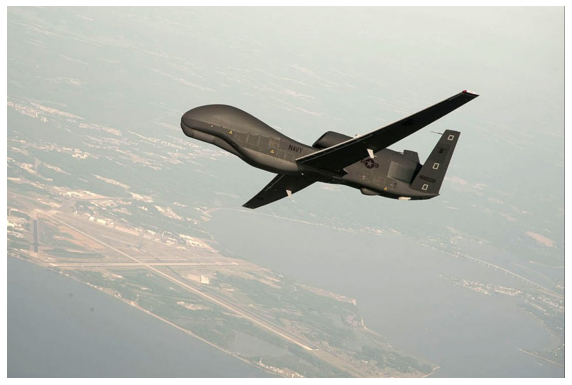

In [138]:
# Display of several results for the 'drone' class
img_path = os.path.join(test_drone_dir, '00000306.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

In the example image '00000306.jpg' you can see, despite the good quality of the photo, depicting a drone. The model struggled to qualify for the correct class, despite using the complex VGG19 architecture (the drone too much like a passenger aircraft?).

(-0.5, 979.5, 691.5, -0.5)

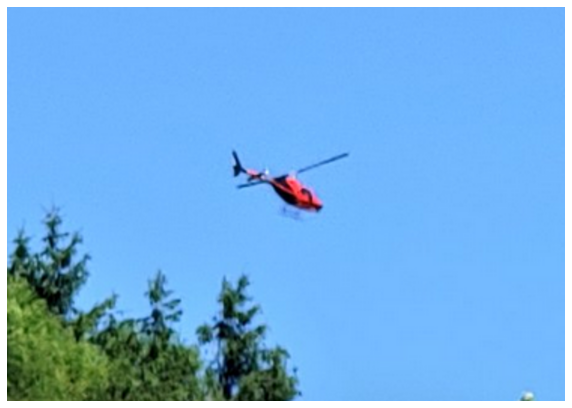

In [139]:
# Showing several results for the class 'helicopter'.
img_path = os.path.join(test_helicopter_dir, '00000207.png')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

Using the example of the photo '00000207.png', it can be concluded that the main reason why the photo was misclassified is because of the poor quality of the photo, the size of the subject and the noise in the trees.

(-0.5, 783.5, 430.5, -0.5)

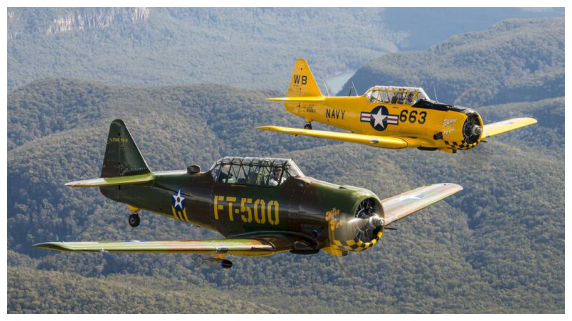

In [140]:
# Showing multiple results for the class 'passenger_plane'.
img_path = os.path.join(test_passenger_plane_dir, '00000225.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

Using photo '00000225.jpg' as an example, one can conclude that the difficulty for the model was the number of objects (two) in the photo, and that it is more of a replica of a military aircraft.

##Summary

As you can see, the data is heavily noisy, while the accuracy of the created model algorithm itself oscillates around 89%, which for three classes is quite a good result. In order to improve the results, images that do not fit into the model/classes should be removed, in which case the accuracy of the model will increase. It is important to note how important it is when working with models that the data you want to work with is. If the data is of poor quality, then our model will not learn much from it. Another thing is the amount of data to be had. Based on the results of our model, you can see that the model works well because it captured data that was noisy i.e. it simply misclassified it because it represented 'something' that should not be in those sets. It should be mentioned that when building the model, we can do some validation on the basis of incorrect predictions.

##References
Data taken from the link: https://www.kaggle.com/datasets/eabdul/flying-vehicles